![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [3]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


In [4]:
cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cc_apps = cc_apps[~cc_apps[cols].isin(['?']).any(axis=1)]

In [5]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    object 
 1   1       659 non-null    object 
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    object 
 9   9       659 non-null    object 
 10  10      659 non-null    int64  
 11  11      659 non-null    object 
 12  12      659 non-null    int64  
 13  13      659 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 77.2+ KB


In [6]:
df_encoded = pd.get_dummies(cc_apps, columns=[0, 3, 4, 5, 6, 8, 9, 11], dtype=int)


In [7]:
df_encoded.head()

,1,2,7,10,12,13,0_a,0_b,3_l,3_u,...,6_o,6_v,6_z,8_f,8_t,9_f,9_t,11_g,11_p,11_s
0,30.83,0.000,1.25,1,0,+,0,1,0,1,...,0,1,0,0,1,0,1,1,0,0
1,58.67,4.460,3.04,6,560,+,1,0,0,1,...,0,0,0,0,1,0,1,1,0,0
2,24.50,0.500,1.50,0,824,+,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
3,27.83,1.540,3.75,5,3,+,0,1,0,1,...,0,1,0,0,1,0,1,1,0,0
4,20.17,5.625,1.71,0,0,+,0,1,0,1,...,0,1,0,0,1,1,0,0,0,1


In [8]:
# Drop target columns to form features X
X = df_encoded.drop([13], axis=1)

# Select target columns
y = df_encoded[13].map({'+': 1, '-': 0})

print(X.head())
print(y.head())

       1      2     7  10   12  0_a  0_b  3_l  3_u  3_y  ...  6_o  6_v  6_z  \
0  30.83  0.000  1.25   1    0    0    1    0    1    0  ...    0    1    0   
1  58.67  4.460  3.04   6  560    1    0    0    1    0  ...    0    0    0   
2  24.50  0.500  1.50   0  824    1    0    0    1    0  ...    0    0    0   
3  27.83  1.540  3.75   5    3    0    1    0    1    0  ...    0    1    0   
4  20.17  5.625  1.71   0    0    0    1    0    1    0  ...    0    1    0   

   8_f  8_t  9_f  9_t  11_g  11_p  11_s  
0    0    1    0    1     1     0     0  
1    0    1    0    1     1     0     0  
2    0    1    1    0     1     0     0  
3    0    1    0    1     1     0     0  
4    0    1    1    0     0     0     1  

[5 rows x 43 columns]
0    1
1    1
2    1
3    1
4    1
Name: 13, dtype: int64


In [9]:
# Convert all column names to strings
X.columns = X.columns.astype(str)
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Logistic Regression

In [11]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],              
    'penalty': ['l2'],                    
    'solver': ['liblinear']               
}

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Setup GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Fit on training data
grid_search.fit(X_train, y_train) 

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test data
y_pred = grid_search.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85        75
           1       0.77      0.88      0.82        57

    accuracy                           0.83       132
   macro avg       0.83      0.84      0.83       132
weighted avg       0.84      0.83      0.83       132



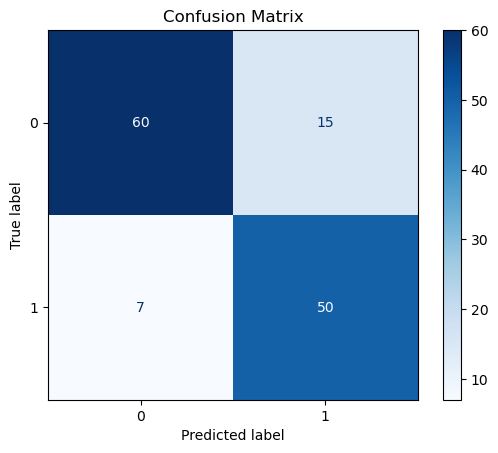

In [12]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [13]:
best_score = grid_search.best_score_
mse = mean_squared_error(y_test, y_pred)

print(f"Best CV Accuracy Score: {best_score:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_pred)))

Best CV Accuracy Score: 0.8803
Mean Squared Error: 0.1667
Accuracy Score is 0.83333


# Decision Tree

In [15]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']  
}

# Initialize DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV with accuracy scoring
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

In [16]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

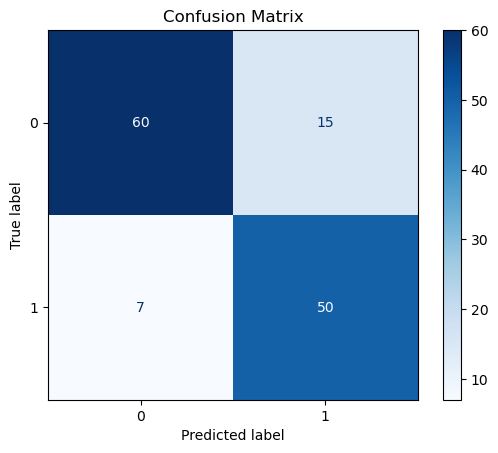

In [17]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [18]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate best cross-validation accuracy score
best_score = grid_search.best_score_
print(f"Best CV Accuracy Score: {best_score:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_pred)))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best CV Accuracy Score: 0.8672
Mean Squared Error: 0.1970
Accuracy Score is 0.80303

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        75
           1       0.77      0.77      0.77        57

    accuracy                           0.80       132
   macro avg       0.80      0.80      0.80       132
weighted avg       0.80      0.80      0.80       132



# Random Forest Classifier

In [20]:
# Define parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with accuracy scoring
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

In [21]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [22]:
# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate best cross-validation accuracy score
best_score = grid_search.best_score_
print(f"Best CV Accuracy Score: {best_score:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_pred)))

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best CV Accuracy Score: 0.8823
Mean Squared Error: 0.1439
Accuracy Score is 0.85606


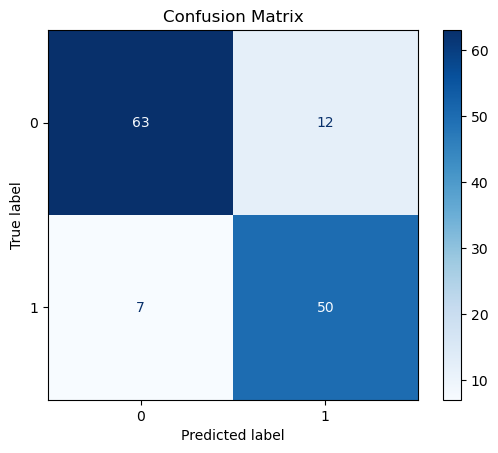


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87        75
           1       0.81      0.88      0.84        57

    accuracy                           0.86       132
   macro avg       0.85      0.86      0.85       132
weighted avg       0.86      0.86      0.86       132



In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# SVM Classifier

In [25]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'kernel': ['linear', 'rbf', 'poly'],  
    'gamma': ['scale', 'auto', 0.1, 1],  
    'degree': [1, 2, 3]  
}

# Initialize SVC
classifier = SVC(random_state=42)

# Set up GridSearchCV with accuracy scoring
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

In [26]:
# Fit the model on scaled data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [27]:
# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate best cross-validation accuracy score
best_score = grid_search.best_score_
print(f"Best CV Accuracy Score: {best_score:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_pred)))

Best Parameters: {'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best CV Accuracy Score: 0.8748
Mean Squared Error: 0.1667
Accuracy Score is 0.83333


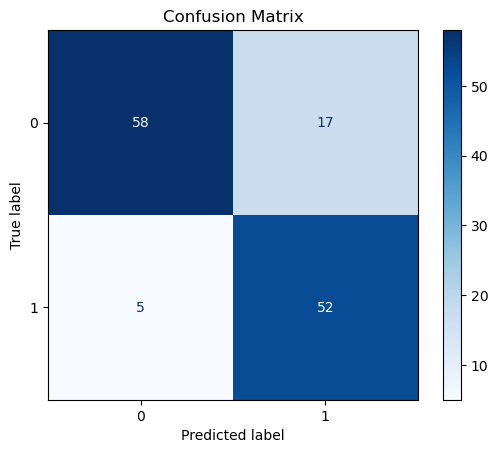


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        75
           1       0.75      0.91      0.83        57

    accuracy                           0.83       132
   macro avg       0.84      0.84      0.83       132
weighted avg       0.85      0.83      0.83       132



In [28]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Gradient Boosting Classifier

In [30]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_features': [3, 4, 5],
    'max_depth': [3, 4, 5]
}

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=100)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

In [31]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'max_features': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [32]:
# Get the best parameters and model
print("Best parameters found:", grid_search.best_params_)
best_gbc = grid_search.best_estimator_

# Make predictions with the best model
pred_y = best_gbc.predict(X_test)

# Calculate and print accuracy
acc = accuracy_score(y_test, y_pred)
print("Gradient Boosting Classifier accuracy is: {:.2f}".format(acc))

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

print("Best cross-validation score: {:.6f}".format(grid_search.best_score_))

Best parameters found: {'learning_rate': 0.01, 'max_depth': 5, 'max_features': 5, 'n_estimators': 200}
Gradient Boosting Classifier accuracy is: 0.83
Mean Squared Error: 0.1667
Best cross-validation score: 0.882318


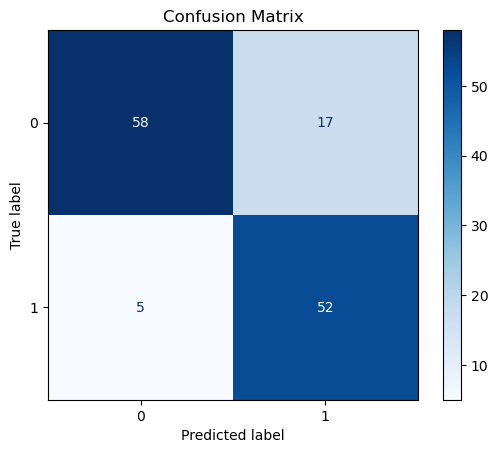


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        75
           1       0.75      0.91      0.83        57

    accuracy                           0.83       132
   macro avg       0.84      0.84      0.83       132
weighted avg       0.85      0.83      0.83       132



In [33]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Light Gradient Boosting Machine

In [35]:
classifier = LGBMClassifier(
    num_leaves=31,
    max_depth=8, 
    learning_rate=0.02,
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8
    )

In [36]:
# Fit the model
classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 241, number of negative: 286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457306 -> initscore=-0.171195
[LightGBM] [Info] Start training from score -0.171195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.02, max_depth=8,
               n_estimators=250, subsample=0.8)

In [37]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate accuracy on test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy Score: {accuracy:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Calculate and print accuracy
acc = accuracy_score(y_test, y_pred)
print("Light Gradient Boosting Classifier accuracy is: {:.2f}".format(acc))

Test Accuracy Score: 0.8333
Mean Squared Error: 0.1667
Light Gradient Boosting Classifier accuracy is: 0.83


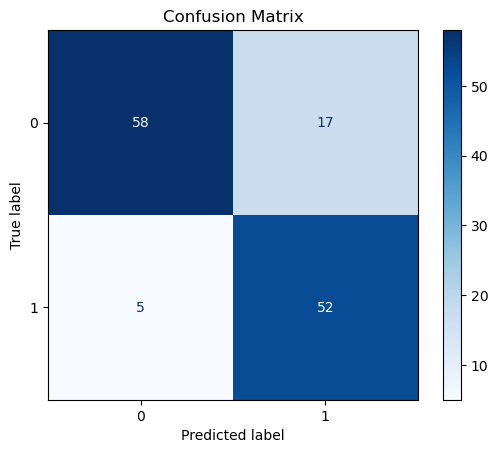


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84        75
           1       0.75      0.91      0.83        57

    accuracy                           0.83       132
   macro avg       0.84      0.84      0.83       132
weighted avg       0.85      0.83      0.83       132



In [38]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))